<a href="https://colab.research.google.com/github/Emmanuel461/Sowing_harvest_predictions/blob/main/Modelado_siembra_2022_planet_k_fold_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelado de siembra año 2022


In [ ]:
# # Definir fechas de siembra
# harvest_dates = {
#     1: '11/12/2022', # +11
#     2: '26/12/2022',
#     3: '20/12/2022',
#     4: '26/12/2022',
#     5: '17/12/2022'
# }


harvest_dates = {
    1: '30/11/2022',
    2: '15/12/2022',
    3: '09/12/2022',
    4: '15/12/2022',
    5: '16/12/2022'
}

In [ ]:
# Instalación de dependencias necesarias
# Ejecuta esto solo una vez si no tienes las librerías instaladas
!pip install geopandas rasterio torchsummary tifffile imagecodecs gdal rasterstats pandas openpyxl torchsummary seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 9.9 MB/s eta 0:00:00


In [ ]:
# Importar las librerías necesarias
import os
import numpy as np
import torch
import rasterio
from datetime import datetime
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from rasterio import features
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torchsummary import summary
import tifffile
import imagecodecs
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut

# Definir el dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Definir el rango de fechas para cargar imágenes (1 de julio de 2022 a 1 de febrero de 2023)
start_date = datetime(2022, 7, 1)
end_date = datetime(2023, 1, 30)

# -----------------------------
# 1. Definición de Constantes y Rutas de Archivos
# -----------------------------

# Rutas de archivos
shapefile_path = '/content/drive/MyDrive/TF_data/DataIn/Parcelas_poligono.geojson'
image_folder_path = '/content/drive/MyDrive/TF_data/Planet_images'  # Carpeta con las imágenes

# -----------------------------
# 2. Lectura y Preparación de Datos Geoespaciales
# -----------------------------

# Leer el GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# Definir fechas de siembra
sowing_dates = {
    1: '27/09/2022',
    2: '23/09/2022',
    3: '28/09/2022',
    4: '25/08/2022',
    5: '17/09/2022'
}

# Convertir las fechas de siembra a días desde una fecha base
base_date = datetime(2022, 7, 1)
sowing_dates_days = {loc_id: (datetime.strptime(date_str, '%d/%m/%Y') - base_date).days for loc_id, date_str in sowing_dates.items()}

# Convertir el diccionario `sowing_dates_days` en un DataFrame para hacer el join
sowing_dates_df = pd.DataFrame(list(sowing_dates_days.items()), columns=['location_id', 'sowing_date_days'])

# Asegurar que ambas columnas 'location_id' sean del mismo tipo
gdf['location_id'] = gdf['location_id'].astype(int)

# Hacer un join entre el `GeoDataFrame` y el `sowing_dates_df`
gdf = gdf.merge(sowing_dates_df, on='location_id', how='left')

# Verificar que se haya realizado el join correctamente
print("GeoDataFrame después del merge:")
print(gdf.head())

# -----------------------------
# 3. Definición de Funciones Auxiliares para Procesamiento de Imágenes
# -----------------------------

# Cargar la lista de rutas de imágenes (.tif o .tiff)
image_paths = sorted([os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if f.endswith(('.tif', '.tiff'))])

# Filtrar las imágenes dentro de un rango de fechas
def filter_images_by_date_range(image_paths, start_date, end_date):
    filtered_paths = []
    for path in image_paths:
        filename = os.path.basename(path)  # Obtener el nombre del archivo
        filename_no_ext, _ = os.path.splitext(filename)  # Eliminar la extensión .tif

        parts = filename_no_ext.split('_')  # Dividir por guiones bajos (_)
        if len(parts) >= 3:
            file_date_str = parts[2]  # El tercer segmento debe contener la fecha: '2022-11-04'
            try:
                # Convertir la cadena de la fecha a un objeto datetime
                file_date = datetime.strptime(file_date_str, '%Y-%m-%d')
                # Solo incluir si la fecha está dentro del rango
                if start_date <= file_date <= end_date:
                    filtered_paths.append(path)
            except ValueError:
                print(f"Error al extraer la fecha del archivo {filename}")
                continue
        else:
            print(f"Formato de nombre de archivo incorrecto: {filename}")
    return filtered_paths

# Buscar bandas por nombre
def select_band_by_name(src, band_names, target_band_names):
    band_indices = []
    for target_band_name in target_band_names:
        if target_band_name in band_names:
            band_index = band_names.index(target_band_name) + 1  # rasterio usa índices 1-based
            band_indices.append(band_index)
        else:
            print(f"La banda '{target_band_name}' no se encontró en el archivo. Bandas disponibles: {band_names}")
            return None
    return src.read(band_indices)

# Función para enmascarar las imágenes usando las geometrías de interés
def mask_image_with_geometries(image, geometries, transform):
    # Crear una máscara basada en las geometrías (parcelas de interés)
    mask = rasterio.features.geometry_mask(geometries, out_shape=(image.shape[1], image.shape[2]), transform=transform, invert=True)
    # Aplicar la máscara a cada banda (los píxeles fuera de la geometría se enmascaran con -1)
    masked_image = np.where(mask, image, -1)
    return masked_image

# Procesar secuencia completa de imágenes y añadir banda de días julianos
def load_sequence_images(image_paths, gdf, target_band_names=['dias_julianos', 'SAVI', 'NDWI', 'NDRE', 'GCVI', 'VARI'], base_date=datetime(2022, 7, 1)):
    sequence = []
    if len(image_paths) == 0:
        print("No se encontraron imágenes para el rango de fechas especificado.")
        return None

    for image_path in image_paths:
        print(f"Cargando y enmascarando imagen: {image_path}")

        # Extraer la fecha de la imagen del nombre (sin la extensión .tif)
        filename = os.path.basename(image_path)
        filename_no_ext, _ = os.path.splitext(filename)  # Separar el nombre y la extensión
        parts = filename_no_ext.split('_')  # Separar por el guion bajo '_'

        if len(parts) < 3:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        image_date_str = parts[2]  # Esto debe contener la fecha, por ejemplo: '2022-09-23'

        try:
            # Convertir la cadena de la fecha a un objeto datetime
            image_date = datetime.strptime(image_date_str, '%Y-%m-%d')
            # Calcular los días julianos
            julian_days = (image_date - base_date).days
        except ValueError:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        with rasterio.open(image_path) as src:
            band_names = list(src.descriptions)  # Obtener los nombres de las bandas
            selected_bands = select_band_by_name(src, band_names, target_band_names[1:])  # Omitir 'dias_julianos' al seleccionar bandas

            if selected_bands is not None:
                selected_bands = selected_bands.astype(np.float32)
                selected_bands[np.isnan(selected_bands)] = -1

                # Crear una banda para los días julianos con el mismo tamaño espacial que las imágenes
                julian_band = np.full((1, selected_bands.shape[1], selected_bands.shape[2]), julian_days, dtype=np.float32)

                # Concatenar la banda de días julianos con las bandas seleccionadas
                stacked_bands = np.vstack((julian_band, selected_bands))

                # Aplicar la máscara de las geometrías de interés
                geometries = gdf['geometry']  # Las geometrías de interés (parcelas)
                masked_bands = mask_image_with_geometries(stacked_bands, geometries, src.transform)

                sequence.append(masked_bands)
            else:
                print(f"No se seleccionaron bandas para la imagen {image_path}.")

    if len(sequence) > 0:
        print(f"Secuencias cargadas con la banda 'dias_julianos'.")
        return np.stack(sequence, axis=0)  # (n_imágenes, n_bandas, alto, ancho)
    else:
        print("No se pudo cargar ninguna imagen.")
        return None

# -----------------------------
# 4. Creación de la Imagen Etiquetada (labeled_image) y location_image
# -----------------------------

# Filtrar las imágenes que están dentro del rango de fechas
image_paths_in_range = filter_images_by_date_range(image_paths, start_date, end_date)

# Cargar y enmascarar las imágenes dentro del rango, incluyendo la banda de días julianos
X_sequences = load_sequence_images(image_paths_in_range, gdf)

# Verificar el shape de X_sequences
if X_sequences is not None:
    print(f"Shape de las secuencias: {X_sequences.shape}")  # (n_imágenes, n_bandas, alto, ancho)
else:
    print("No se cargaron secuencias.")




Usando dispositivo: cpu
GeoDataFrame después del merge:
   location_id  area_ha   area_m2  polygon_id  \
0            3   0.0140   140.182           1   
1            4   0.0588   587.821           2   
2            1   0.0417   417.453           3   
3            5   0.1239  1239.167           4   
4            2   0.1210  1209.867           5   

                                            geometry  sowing_date_days  
0  MULTIPOLYGON (((-16.45195 12.24527, -16.45194 ...                89  
1  MULTIPOLYGON (((-16.44898 12.24448, -16.44899 ...                55  
2  MULTIPOLYGON (((-16.4436 12.24348, -16.44354 1...                88  
3  MULTIPOLYGON (((-16.44025 12.2486, -16.44033 1...                78  
4  MULTIPOLYGON (((-16.44462 12.24446, -16.44461 ...                84  
Cargando y enmascarando imagen: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-07-09.tif
Cargando y enmascarando imagen: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-08-31.tif
C

In [ ]:
# Crear la imagen etiquetada 'labeled_image'
# Inicializar una matriz para las etiquetas
labeled_image = np.full(X_sequences.shape[2:], -1, dtype=np.float32)

# Obtener la referencia espacial de una de las imágenes
with rasterio.open(image_paths_in_range[0]) as src:
    out_meta = src.meta.copy()
    out_transform = src.transform

height, width = labeled_image.shape
location_image = np.full((height, width), np.nan)

# Iterar sobre las geometrías y asignar etiquetas
for idx, row in gdf.iterrows():
    loc_id = row['location_id']
    sowing_dates_days = row['sowing_date_days']
    parcel_geometry = [row['geometry']]

    # Crear una máscara para la geometría de la parcela
    mask_array = rasterio.features.geometry_mask(
        parcel_geometry,
        out_shape=(height, width),
        transform=out_transform,
        invert=True,
        all_touched=True
    )

    # Asignar la fecha de cosecha a los píxeles de la parcela
    labeled_image[mask_array] = sowing_dates_days
    location_image[mask_array] = loc_id

# Verificar si hay valores NaN
print(f"Hay NaNs en labeled_image: {np.isnan(labeled_image).any()}")
print(f"Hay NaNs en X_sequences: {np.isnan(X_sequences).any()}")


Hay NaNs en labeled_image: False
Hay NaNs en X_sequences: False


In [ ]:
# Reorganizar los datos para la CNN 3D
num_images, num_bands, height, width = X_sequences.shape

# Reorganizar a la forma (n_bandas, n_imágenes, alto, ancho)
X = X_sequences.transpose(1, 0, 2, 3)  # (n_bandas, n_imágenes, alto, ancho)
X = X.astype(np.float32)

# Preparar las etiquetas
y = labeled_image.astype(np.float32)  # (alto, ancho)

# Reemplazar NaNs en y con -1
y[np.isnan(y)] = -1

# Reemplazar NaNs en X_sequences con -1
X_sequences[np.isnan(X_sequences)] = -1

# Reorganizar los datos para el modelo sin parches
num_bands, num_images, height, width = X.shape  # X es de forma (n_bandas, n_imágenes, alto, ancho)

# Aplanar X a (n_samples, n_bandas, n_imágenes)
X_flat = X.reshape(num_bands, num_images, -1).transpose(2, 0, 1)  # (n_samples, n_bandas, n_imágenes)

# Aplanar y a (n_samples,)
y_flat = y.flatten()  # (n_samples,)

# Aplanar location_image a (n_samples,)
location_flat = location_image.flatten()

# Crear máscara para filtrar píxeles con etiquetas válidas
valid_mask = ~np.isnan(y_flat) & (y_flat != -1)

# Filtrar X, y y location_id con la máscara
X_flat_valid = X_flat[valid_mask]  # (n_valid_samples, n_bandas, n_imágenes)
y_flat_valid = y_flat[valid_mask]  # (n_valid_samples,)
location_flat_valid = location_flat[valid_mask]  # (n_valid_samples,)

# Verificar que hay datos válidos
if X_flat_valid.shape[0] == 0:
    raise ValueError("No se encontraron píxeles con etiquetas válidas. Verifica tus datos.")

print(f"Shape de X_flat_valid: {X_flat_valid.shape}")
print(f"Shape de y_flat_valid: {y_flat_valid.shape}")
print(f"Shape de location_flat_valid: {location_flat_valid.shape}")


Shape de X_flat_valid: (525, 6, 52)
Shape de y_flat_valid: (525,)
Shape de location_flat_valid: (525,)


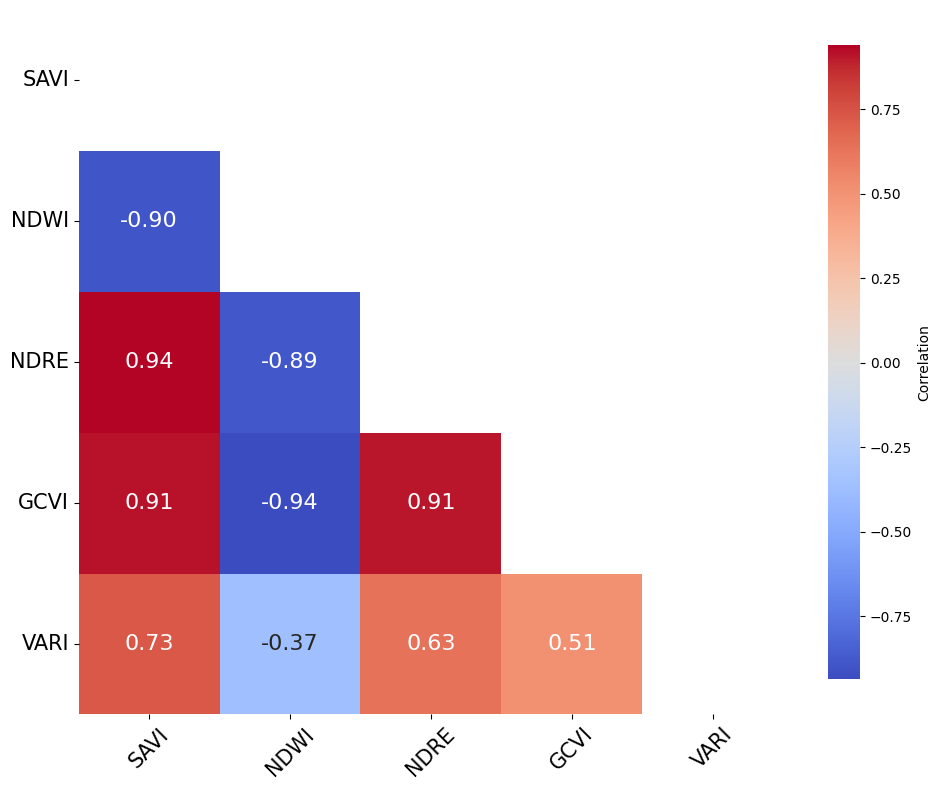

Pares de bandas altamente correlacionadas (umbral > 0.95):


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Suponiendo que ya tenemos las siguientes variables definidas:
# - X_sequences: con forma (n_imágenes, n_bandas_total, alto, ancho)
# - y_flat_valid: etiquetas correspondientes a los píxeles válidos, de forma (n_valid_pixels,)
# - X_flat_valid: datos de entrada correspondientes a los píxeles válidos, de forma (n_valid_pixels, n_bandas_total, n_imágenes)

# Actualizar los labels de las bandas, excluyendo 'Julian Days'
band_labels = ['SAVI', 'NDWI', 'NDRE', 'GCVI', 'VARI']

# Verificar que X_flat_valid tiene las bandas correctas y en el orden especificado
# Excluimos la banda 'Julian Days' (suponiendo que es la primera banda)

n_valid_pixels, n_bandas_total, n_imágenes = X_flat_valid.shape

# Crear un índice para seleccionar las bandas a incluir (excluyendo 'Julian Days')
bands_to_include_indices = [i for i in range(n_bandas_total) if i != 0]  # Excluye índice 0

# Seleccionar las bandas correspondientes en X_flat_valid
X_flat_valid_selected = X_flat_valid[:, bands_to_include_indices, :]  # Forma: (n_valid_pixels, n_bandas_seleccionadas, n_imágenes)

# Actualizar n_bandas
n_bandas = X_flat_valid_selected.shape[1]

# Transponer y aplanar para obtener (n_valid_pixels * n_imágenes, n_bandas)
X_for_corr = X_flat_valid_selected.transpose(0, 2, 1).reshape(-1, n_bandas)

# Reemplazar valores -1 por NaN
X_for_corr[X_for_corr == -1] = np.nan

# Eliminar las filas (muestras) que tienen valores NaN en cualquier banda
valid_mask = ~np.isnan(X_for_corr).any(axis=1)
X_for_corr_valid = X_for_corr[valid_mask]

# Calcular la matriz de correlación de Pearson entre las bandas
correlation_matrix = np.corrcoef(X_for_corr_valid, rowvar=False)

# Crear una máscara para mostrar solo la mitad inferior de la matriz de correlación
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Visualizar la matriz de correlación con la máscara aplicada
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=band_labels, yticklabels=band_labels, center=0, square=True,
            annot_kws={"size": 16},  # Tamaño de los números de correlación
            cbar_kws={'label': 'Correlation', 'shrink': 0.9, 'orientation': 'vertical'})  # Ajuste del colorbar

# Configuraciones adicionales para el tamaño de los elementos
plt.title('', fontsize=16)  # Tamaño del título
plt.xticks(rotation=45, fontsize=15)  # Tamaño y rotación de etiquetas del eje X
plt.yticks(rotation=0, fontsize=15)   # Tamaño de etiquetas del eje Y
plt.tight_layout()  # Ajuste de la disposición

# Mostrar el gráfico
plt.show()

# Definir umbral de correlación
correlation_threshold = 0.95

# Encontrar pares de bandas con alta correlación
highly_correlated_pairs = []
for i, j in itertools.combinations(range(n_bandas), 2):
    corr_value = correlation_matrix[i, j]
    if abs(corr_value) > correlation_threshold:
        highly_correlated_pairs.append((i, j, corr_value))

# Imprimir bandas altamente correlacionadas
print("Pares de bandas altamente correlacionadas (umbral > 0.95):")
for i, j, corr_value in highly_correlated_pairs:
    print(f"{band_labels[i]} y {band_labels[j]}: correlación = {corr_value:.4f}")




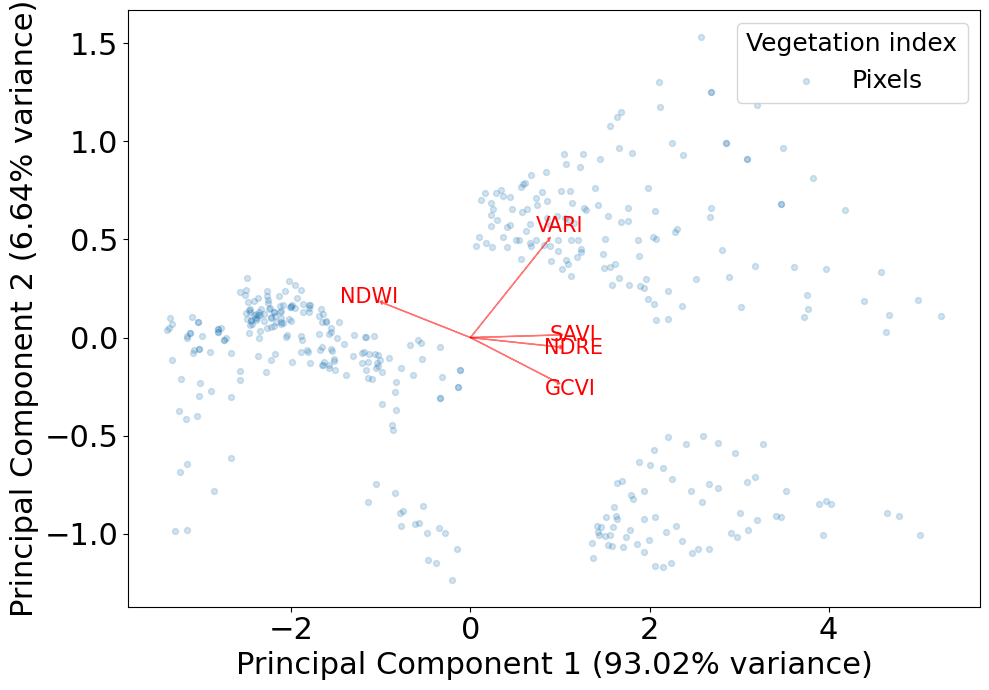

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Suponiendo que ya tienes las siguientes variables definidas:
# - X_flat_valid: datos de entrada correspondientes a los píxeles válidos, de forma (n_valid_pixels, n_bandas_total, n_imágenes)
# - y_flat_valid: etiquetas correspondientes a los píxeles válidos, de forma (n_valid_pixels,)

# Actualizar los labels de las bandas, excluyendo 'Julian Days'
band_labels = ['SAVI', 'NDWI', 'NDRE', 'GCVI', 'VARI']

# Verificar que X_flat_valid tiene las bandas correctas y en el orden especificado
# Excluimos la banda 'Julian Days' (suponiendo que es la primera banda)

n_valid_pixels, n_bandas_total, n_imágenes = X_flat_valid.shape

# Crear un índice para seleccionar las bandas a incluir (excluyendo 'Julian Days')
bands_to_include_indices = [i for i in range(n_bandas_total) if i != 0]  # Excluye índice 0

# Seleccionar las bandas correspondientes en X_flat_valid
X_flat_valid_selected = X_flat_valid[:, bands_to_include_indices, :]  # Forma: (n_valid_pixels, n_bandas_seleccionadas, n_imágenes)

# Actualizar n_bandas
n_bandas = X_flat_valid_selected.shape[1]

# Paso 1: Promediar las bandas a través del tiempo para reducir la dimensionalidad
# Esto nos dará una matriz de forma (n_valid_pixels, n_bandas)
X_mean_time = np.mean(X_flat_valid_selected, axis=2)  # Promedia a lo largo de la dimensión del tiempo

# Reemplazar valores -1 por NaN
X_mean_time[X_mean_time == -1] = np.nan

# Paso 2: Eliminar muestras con valores faltantes o inválidos
valid_mask = ~np.isnan(X_mean_time).any(axis=1)
X_mean_time_valid = X_mean_time[valid_mask]

# Paso 3: Escalar los datos antes de PCA (media cero y varianza unitaria)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mean_time_valid)

# Paso 4: Realizar PCA
n_components = 2  # Para el biplot, necesitamos dos componentes principales
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)

# Obtener el porcentaje de varianza explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_ * 100  # Convertir a porcentaje

# Paso 5: Obtener las cargas (loadings) de las variables originales
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Paso 6: Crear el biplot
plt.figure(figsize=(10, 7))

# Plot de los scores (proyecciones de las muestras en los componentes principales)
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.2, s=18, label='Pixels')

# Añadir vectores de las variables originales (loadings)
for i, (loading_x, loading_y) in enumerate(loadings):
    plt.arrow(0, 0, loading_x, loading_y, color='red', alpha=0.5, head_width=0.02)
    plt.text(loading_x * 1.15, loading_y * 1.15, band_labels[i], color='red', ha='center', va='center', fontsize=15)

# Actualizar las etiquetas de los ejes para incluir el porcentaje de varianza explicada
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]:.2f}% variance)', fontsize=22)
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]:.2f}% variance)', fontsize=22)

# Ajustar el tamaño del título y añadir uno (si es necesario)
plt.title('', fontsize=16)

# Configuración de la leyenda
plt.legend(title='Vegetation index', fontsize=18, title_fontsize='18', loc='upper right')

# Ajustes adicionales para mejorar la visualización
plt.grid(False)  # Opcional: desactivar la cuadrícula
plt.xticks(fontsize=22)  # Tamaño de las etiquetas en el eje X
plt.yticks(fontsize=22)  # Tamaño de las etiquetas en el eje Y
plt.tight_layout()  # Ajuste de la disposición

# Mostrar el gráfico
plt.show()



In [ ]:
pip install torchviz

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.5 MB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=18ca99e976d93027a92eb6da3f07570a09be4e4f15df451d0cd9f2e9c5726e78
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
# 1. Dataset

import torch
from torchviz import make_dot
import torch.nn as nn


# Reemplaza estas variables con tus datos reales

# 1. Dataset

# Reemplaza estas variables con tus datos reales

# Definir el dataset personalizado
class PixelDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Convertir a tensores y ajustar dimensiones para que sean compatibles con el modelo
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        X = X.unsqueeze(-1).unsqueeze(-1)  # Agregar dimensiones espaciales ficticias (1x1)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y

# Definir el Modelo CNN 3D Pixel a Pixel sin capas de normalización
class CNN3DModelPixelwise(nn.Module):
    def __init__(self, num_bands, num_images, dropout_rate=0.1):
        super(CNN3DModelPixelwise, self).__init__()

        # Capas convolucionales ajustadas para dimensiones espaciales de 1x1
        self.conv1 = nn.Conv3d(in_channels=num_bands, out_channels=32,
                               kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.conv1b = nn.Conv3d(in_channels=32, out_channels=32,
                                kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64,
                               kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.conv2b = nn.Conv3d(in_channels=64, out_channels=64,
                                kernel_size=(3, 1, 1), padding=(1, 0, 0))
        # Capa de convolución temporal para condensar la información temporal
        self.conv_temporal = nn.Conv3d(in_channels=64, out_channels=64,
                                       kernel_size=(num_images, 1, 1))
        # Capa final de convolución
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=1, kernel_size=1)

        # Dropout para la regularización
        self.dropout = nn.Dropout3d(p=dropout_rate)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout(x)

        x = torch.relu(self.conv1b(x))
        x = self.dropout(x)

        x = torch.relu(self.conv2(x))
        x = self.dropout(x)

        x = torch.relu(self.conv2b(x))
        x = self.dropout(x)

        x = torch.relu(self.conv_temporal(x))
        x = self.dropout(x)

        x = self.conv3(x)
        x = x.squeeze()
        return x

In [ ]:
# Genera un tensor de entrada de prueba
x = x = torch.randn(1, num_bands, num_images, 3, 3)  # Aumentar el tamaño espacial a 3x3 o más
model = CNN3DModelPixelwise(num_bands, num_images)

# Pasa el tensor por el modelo
y = model(x)

# Genera el gráfico de la arquitectura
dot = make_dot(y, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('cnn3d_model')

'cnn3d_model.png'

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupShuffleSplit, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Configurar el dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando el dispositivo: {device}")

# Establecer semillas para reproducibilidad
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# 2. División en datos de entrenamiento y prueba, especificando el grupo a dejar fuera
X = X_flat_valid
y = y_flat_valid
groups = location_flat_valid.astype(int)

# Especificar el grupo que deseas dejar fuera como conjunto de prueba
test_group = 3  # Cambia este valor al grupo que quieras dejar fuera

# Crear máscaras para separar los datos
train_mask = groups != test_group
test_mask = groups == test_group

# Dividir los datos en entrenamiento y prueba según las máscaras
X_train = X[train_mask]
y_train = y[train_mask]
groups_train = groups[train_mask]

X_test = X[test_mask]
y_test = y[test_mask]
groups_test = groups[test_mask]

print(f"Número de muestras en entrenamiento: {len(X_train)}")
print(f"Número de muestras en prueba (grupo {test_group}): {len(X_test)}")
print(f"Grupos en entrenamiento: {np.unique(groups_train)}")
print(f"Grupos en prueba: {np.unique(groups_test)}")

Usando el dispositivo: cpu
Número de muestras en entrenamiento: 496
Número de muestras en prueba (grupo 3): 29
Grupos en entrenamiento: [1 2 4 5]
Grupos en prueba: [3]


In [ ]:
# 3. Parámetros
# Definir la rejilla de hiperparámetros para el ajuste
param_grid = {
    'learning_rate': [0.08,0.05, 0.1, 0.001],
    'dropout_rate': [0.01, 0.1],
    'optimizer': ['Adam', 'Adagrad']
}

grid = list(ParameterGrid(param_grid))

# Obtener los valores únicos de y_train y y_test
unique_y_train = np.unique(y_train)
unique_y_test = np.unique(y_test)

print("Valores únicos en y_train:", unique_y_train)
print("Valores únicos en y_test:", unique_y_test)

# 4. Validación cruzada k-fold en los datos de entrenamiento
unique_groups = np.unique(groups_train)
n_splits = min(4, len(unique_groups))
random_state = 42

from sklearn.model_selection import GroupKFold

Valores únicos en y_train: [55. 78. 84. 88.]
Valores únicos en y_test: [89.]


In [ ]:
gkf = GroupKFold(n_splits=n_splits)

# Variables para almacenar los mejores hiperparámetros y score
best_params = None
best_score = np.inf  # Porque queremos minimizar el RMSE

for params in grid:
    print(f"\nEvaluando hiperparámetros: {params}")
    fold_metrics = []

    # Configurar los hiperparámetros actuales
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']

    for fold, (train_idx_fold, val_idx_fold) in enumerate(gkf.split(X_train, y_train, groups=groups_train)):
        print(f"  Fold {fold + 1}/{n_splits}")
        print(f"    Número de muestras en entrenamiento: {len(train_idx_fold)}")
        print(f"    Número de muestras en validación: {len(val_idx_fold)}")

        # Verificar que el conjunto de validación no esté vacío
        if len(val_idx_fold) == 0:
            print(f"    Fold {fold + 1} omitido por falta de muestras en validación.")
            continue

        # Dividir los datos en entrenamiento y validación
        X_fold_train, X_fold_val = X_train[train_idx_fold], X_train[val_idx_fold]
        y_fold_train, y_fold_val = y_train[train_idx_fold], y_train[val_idx_fold]

        # Normalizar los datos basados en X_fold_train
        num_bands = X_fold_train.shape[1]
        num_images = X_fold_train.shape[2]

        means = np.mean(X_fold_train, axis=(0, 2))
        stds = np.std(X_fold_train, axis=(0, 2))
        stds[stds == 0] = 1  # Evitar divisiones por cero

        def normalize_data(X, means, stds):
            return (X - means[np.newaxis, :, np.newaxis]) / stds[np.newaxis, :, np.newaxis]

        X_fold_train_norm = normalize_data(X_fold_train, means, stds)
        X_fold_val_norm = normalize_data(X_fold_val, means, stds)

        # Crear datasets y dataloaders
        train_dataset = PixelDataset(X_fold_train_norm, y_fold_train)
        val_dataset = PixelDataset(X_fold_val_norm, y_fold_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Definir el modelo con los hiperparámetros actuales
        model = CNN3DModelPixelwise(num_bands=num_bands, num_images=num_images, dropout_rate=dropout_rate).to(device)

        # Definir la función de pérdida y el optimizador
        criterion = nn.L1Loss()
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name == 'Adagrad':
            optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

        # Entrenar el modelo en X_fold_train
        num_epochs = 60  # Ajusta según sea necesario
        for epoch in range(num_epochs):
            model.train()
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Evaluar el modelo en el conjunto de entrenamiento para calcular R²
        model.eval()
        all_train_preds = []
        all_train_trues = []
        with torch.no_grad():
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                preds = outputs.cpu().numpy()
                trues = targets.cpu().numpy()

                all_train_preds.extend(preds)
                all_train_trues.extend(trues)

        # Evaluar el modelo en el conjunto de validación
        all_val_preds = []
        all_val_trues = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                preds = outputs.cpu().numpy()
                trues = targets.cpu().numpy()

                all_val_preds.extend(preds)
                all_val_trues.extend(trues)

        # Calcular métricas para el conjunto de validación
        if len(all_val_trues) > 0:
            val_rmse = np.sqrt(mean_squared_error(all_val_trues, all_val_preds))
            val_mae = mean_absolute_error(all_val_trues, all_val_preds)
            val_bias = np.mean(np.array(all_val_preds) - np.array(all_val_trues))
            val_pbias = 100 * np.sum(np.array(all_val_preds) - np.array(all_val_trues)) / np.sum(np.array(all_val_trues))
        else:
            val_rmse = np.nan
            val_mae = np.nan
            val_bias = np.nan
            val_pbias = np.nan

        print(f"    RMSE en validación: {val_rmse:.4f}")
        print(f"    MAE en validación: {val_mae:.4f}")
        print(f"    Bias en validación: {val_bias:.4f}")
        print(f"    PBIAS en validación: {val_pbias:.4f}%")

        # Guardar las métricas de este fold
        fold_metric = {
            'val_rmse': val_rmse,
            'val_mae': val_mae,
            'val_bias': val_bias,
            'val_pbias': val_pbias
        }
        fold_metrics.append(fold_metric)

    # Calcular las métricas promedio de todos los folds
    mean_metrics = {
        'mean_val_rmse': np.nanmean([m['val_rmse'] for m in fold_metrics]),
        'mean_val_mae': np.nanmean([m['val_mae'] for m in fold_metrics]),
        'mean_val_bias': np.nanmean([m['val_bias'] for m in fold_metrics]),
        'mean_val_pbias': np.nanmean([m['val_pbias'] for m in fold_metrics]),
    }

    # Imprimir las métricas promedio
    print(f"Resultados promedio para los hiperparámetros {params}:")
    print(f"  RMSE promedio en validación: {mean_metrics['mean_val_rmse']:.4f}")
    print(f"  MAE promedio en validación: {mean_metrics['mean_val_mae']:.4f}")
    print(f"  Bias promedio en validación: {mean_metrics['mean_val_bias']:.4f}")
    print(f"  PBIAS promedio en validación: {mean_metrics['mean_val_pbias']:.4f}%")


    # Actualizar los mejores hiperparámetros si es necesario
    if mean_metrics['mean_val_rmse'] < best_score:
        best_score = mean_metrics['mean_val_rmse']
        best_params = params

print(f"\nMejores hiperparámetros encontrados: {best_params} con RMSE promedio en validación de {best_score:.4f}")

Epoch 1/60, Loss: 33.5427
Epoch 2/60, Loss: 13.3582
Epoch 3/60, Loss: 8.8979
Epoch 4/60, Loss: 8.7922
Epoch 5/60, Loss: 7.2690
Epoch 6/60, Loss: 10.0641
Epoch 7/60, Loss: 6.4320
Epoch 8/60, Loss: 6.8115
Epoch 9/60, Loss: 6.5910
Epoch 10/60, Loss: 5.5201
Epoch 11/60, Loss: 6.2504
Epoch 12/60, Loss: 5.9560
Epoch 13/60, Loss: 6.6240
Epoch 14/60, Loss: 7.3822
Epoch 15/60, Loss: 6.1090
Epoch 16/60, Loss: 8.1923
Epoch 17/60, Loss: 5.2594
Epoch 18/60, Loss: 4.8936
Epoch 19/60, Loss: 4.4764
Epoch 20/60, Loss: 5.1989
Epoch 21/60, Loss: 4.2566
Epoch 22/60, Loss: 3.9348
Epoch 23/60, Loss: 3.8316
Epoch 24/60, Loss: 3.7124
Epoch 25/60, Loss: 4.3831
Epoch 26/60, Loss: 4.5930
Epoch 27/60, Loss: 3.9912
Epoch 28/60, Loss: 4.2271
Epoch 29/60, Loss: 3.6369
Epoch 30/60, Loss: 3.9882
Epoch 31/60, Loss: 4.5181
Epoch 32/60, Loss: 4.6177
Epoch 33/60, Loss: 3.6153
Epoch 34/60, Loss: 3.5675
Epoch 35/60, Loss: 3.9316
Epoch 36/60, Loss: 3.5929
Epoch 37/60, Loss: 4.2302
Epoch 38/60, Loss: 5.3718
Epoch 39/60, Loss:

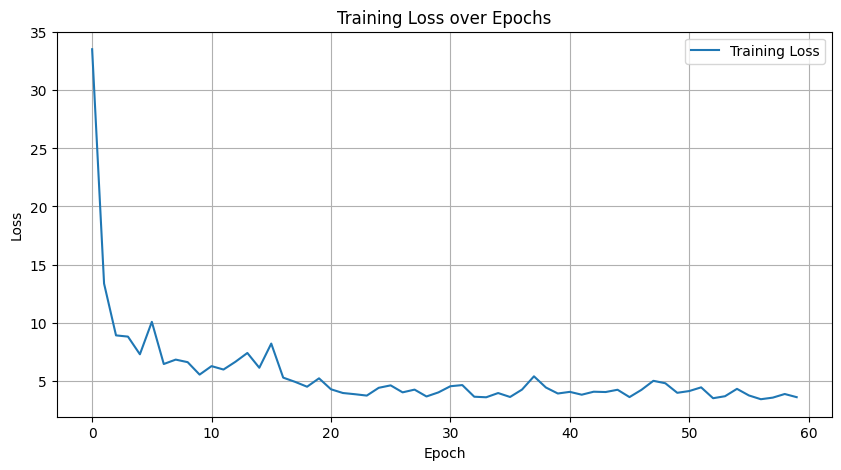

In [ ]:
# 5. Reentrenamiento con los mejores parámetros
# Normalizar los datos de entrenamiento completos
num_bands = X_train.shape[1]
num_images = X_train.shape[2]

means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)
stds[stds == 0] = 1

def normalize_data(X, means, stds):
    return (X - means[np.newaxis, :, :]) / stds[np.newaxis, :, :]

X_train_norm = normalize_data(X_train, means, stds)

# Crear el dataset y dataloader para los datos de entrenamiento completos
train_dataset = PixelDataset(X_train_norm, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

# Crear el modelo con los mejores hiperparámetros
dropout_rate = 0.01
learning_rate = 0.01
optimizer_name = best_params['optimizer']

model = CNN3DModelPixelwise(num_bands=num_bands, num_images=num_images, dropout_rate=dropout_rate).to(device)

# Definir la función de pérdida y el optimizador con los mejores hiperparámetros
criterion = nn.L1Loss()
if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_name == 'Adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

# Entrenar el modelo
num_epochs = 60   # Ajusta según sea necesario
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Evaluar el modelo en el conjunto de entrenamiento completo
model.eval()
all_train_preds = []
all_train_trues = []

with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        all_train_preds.extend(outputs.cpu().numpy())
        all_train_trues.extend(targets.cpu().numpy())

# Calcular métricas en el conjunto de entrenamiento completo
train_mse = mean_squared_error(all_train_trues, all_train_preds)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(all_train_trues, all_train_preds)
train_r2 = r2_score(all_train_trues, all_train_preds)
train_bias = np.mean(np.array(all_train_preds) - np.array(all_train_trues))
train_pbias = 100 * np.sum(np.array(all_train_preds) - np.array(all_train_trues)) / np.sum(np.array(all_train_trues))

print('\nMétricas en el Conjunto de Entrenamiento:')
print(f'RMSE: {train_rmse:.4f}')
print(f'MAE: {train_mae:.4f}')
print(f'R²: {train_r2:.4f}')
print(f'Bias: {train_bias:.4f}')
print(f'PBIAS: {train_pbias:.4f}%')

# Plot de la función de pérdida durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Crear un DataFrame con los valores observados y predichos del conjunto de prueba
df_test_results = pd.DataFrame({
    'Valores Observados': np.array(all_train_trues).reshape(-1),
    'Valores Predichos': np.array(all_train_preds).reshape(-1)
})

# Especificar la ruta y el nombre del archivo Excel para el conjunto de prueba
excel_test_file_path = '/content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_training_planet.xlsx'

# Guardar el DataFrame en un archivo Excel
df_test_results.to_excel(excel_test_file_path, index=False)

print(f"Resultados del conjunto de prueba exportados exitosamente a {excel_test_file_path}")

Resultados del conjunto de prueba exportados exitosamente a /content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_training_planet.xlsx


R²: 0.7564
RMSE: 5.3167
MAE: 2.3756
Bias: -0.0482
PBIAS: -0.0622%
Pearson Correlation: 0.8701


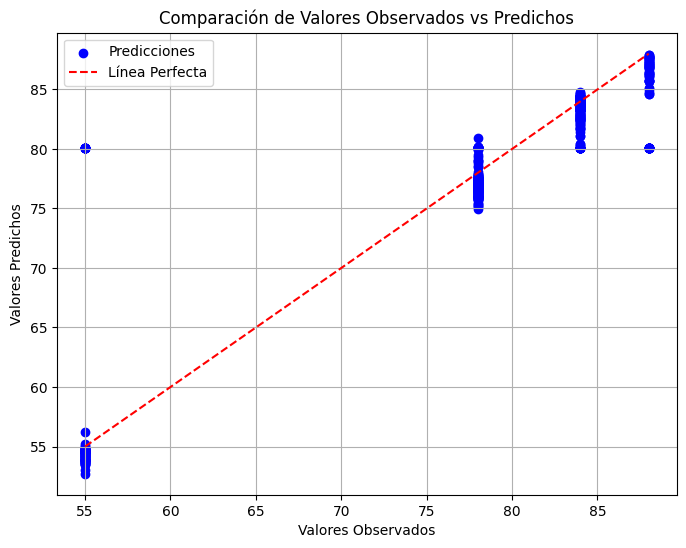

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Especificar la ruta del archivo Excel
excel_file_path = '/content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_training_planet.xlsx'

# Leer el archivo Excel
df_results = pd.read_excel(excel_file_path)

# Extraer los valores observados y predichos
observed_values = df_results['Valores Observados']
predicted_values = df_results['Valores Predichos']

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(observed_values, predicted_values))

# Calcular MAE
mae = mean_absolute_error(observed_values, predicted_values)

# Calcular R²
r2 = r2_score(observed_values, predicted_values)

# Calcular Bias
bias = np.mean(predicted_values - observed_values)

# Calcular PBIAS
pbias = 100 * np.sum(predicted_values - observed_values) / np.sum(observed_values)

# Calcular Correlación de Pearson
pearson_corr, _ = pearsonr(observed_values, predicted_values)

# Mostrar los resultados
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Bias: {bias:.4f}")
print(f"PBIAS: {pbias:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Generar el gráfico de valores observados vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(observed_values,predicted_values , label='Predicciones', color='blue')
plt.plot([observed_values.min(), observed_values.max()],
         [observed_values.min(), observed_values.max()],
         color='red', label='Línea Perfecta', linestyle='--')

plt.title('Comparación de Valores Observados vs Predichos')
plt.xlabel('Valores Observados')
plt.ylabel('Valores Predichos')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 6. Evaluación final en el conjunto de prueba
# Normalizar los datos de prueba usando las estadísticas de los datos de entrenamiento
X_test_norm = normalize_data(X_test, means, stds)

# Crear el dataset y dataloader para los datos de prueba
test_dataset = PixelDataset(X_test_norm, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluar el modelo en los datos de prueba
model.eval()

all_test_predictions = []
all_test_true_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        preds = outputs.cpu().numpy()
        trues = targets.cpu().numpy()

        all_test_predictions.extend(preds)
        all_test_true_values.extend(trues)

# Calcular métricas en los datos de prueba
mse = mean_squared_error(all_test_true_values, all_test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_test_true_values, all_test_predictions)
r2 = r2_score(all_test_true_values, all_test_predictions)
bias = np.mean(np.array(all_test_predictions) - np.array(all_test_true_values))
pbias = 100 * np.sum(np.array(all_test_predictions) - np.array(all_test_true_values)) / np.sum(np.array(all_test_true_values))


print('\nMétricas en el Conjunto de Prueba:')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')
print(f'Bias: {bias:.4f}')
print(f'PBIAS: {pbias:.4f}%')


Métricas en el Conjunto de Prueba:
RMSE: 9.4575
MAE: 9.4378
R²: 0.0000
Bias: -9.4378
PBIAS: -10.6043%


In [ ]:
import pandas as pd

# Crear un DataFrame con los valores observados y predichos del conjunto de prueba
df_test_results = pd.DataFrame({
    'Valores Observados': np.array(all_test_predictions).reshape(-1),
    'Valores Predichos': np.array(all_test_true_values).reshape(-1)
})

# Especificar la ruta y el nombre del archivo Excel para el conjunto de prueba
excel_test_file_path = '/content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_testing_planet.xlsx'

# Guardar el DataFrame en un archivo Excel
df_test_results.to_excel(excel_test_file_path, index=False)

print(f"Resultados del conjunto de prueba exportados exitosamente a {excel_test_file_path}")

Resultados del conjunto de prueba exportados exitosamente a /content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_testing_planet.xlsx


In [ ]:
# Guardado del modelo final
model_path = "/content/drive/MyDrive/TF_data/Predictions/modelo_siembra_2022_planet.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'means': means,
    'stds': stds,
    'num_bands': num_bands,
    'num_images': num_images,
    'best_params': best_params
}, model_path)

print(f"\nModelo final guardado en {model_path}")


Modelo final guardado en /content/drive/MyDrive/TF_data/Predictions/modelo_siembra_2022_planet.pth


In [ ]:
# Paso 1: Cargar el modelo guardado y sus parámetros

# Guardado del modelo final
model_path = "/content/drive/MyDrive/TF_data/Predictions/modelo_siembra_2022_planet.pth"

model = CNN3DModelPixelwise(num_bands=num_bands, num_images=num_images).to(device)

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
means = checkpoint['means']
stds = checkpoint['stds']
num_bands = checkpoint['num_bands']
num_images = checkpoint['num_images']
model.eval()  # Cambiar a modo de evaluación

<ipython-input-18-c2c36488d5af>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


CNN3DModelPixelwise(
  (conv1): Conv3d(6, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv1b): Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv2): Conv3d(32, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv2b): Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv_temporal): Conv3d(64, 64, kernel_size=(52, 1, 1), stride=(1, 1, 1))
  (conv3): Conv3d(64, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (dropout): Dropout3d(p=0.1, inplace=False)
)

Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-07-09.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-08-31.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-09-23.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-09-28.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-10-01.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-10-10.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-10-19.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-10-27.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_

<ipython-input-19-1a52794a9967>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Imagen predicha guardada en /content/drive/MyDrive/TF_data/Fechas de siembra predichas/predicciones_fecha_siembra_2022_validacion_cruzada_planet.tif


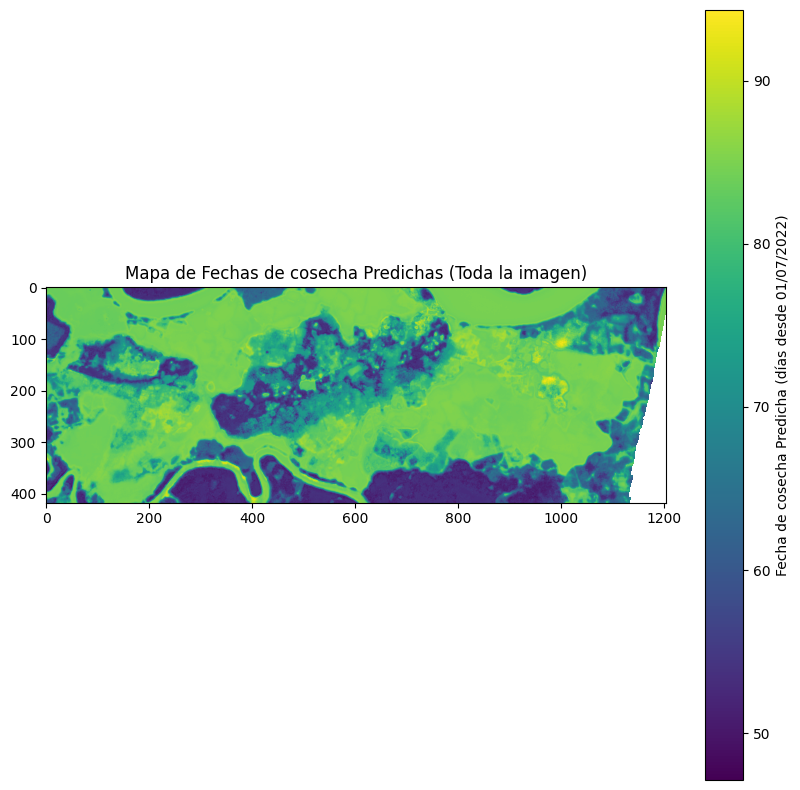

In [ ]:
# Cargar la imagen completa para predicción
def load_full_sequence_images(image_paths, target_band_names=['dias_julianos', 'SAVI', 'NDWI', 'NDRE', 'GCVI', 'VARI']):
    sequence = []
    if len(image_paths) == 0:
        print("No se encontraron imágenes para el año especificado.")
        return None

    for image_path in image_paths:
        print(f"Cargando imagen completa para predicción: {image_path}")

        # Extraer la fecha de la imagen del nombre del archivo
        filename = os.path.basename(image_path)
        filename_no_ext, _ = os.path.splitext(filename)  # Eliminar la extensión (.tif)
        parts = filename_no_ext.split('_')

        if len(parts) < 3:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        # Extraer la fecha de la imagen
        image_date_str = parts[2]  # Esto debe contener la fecha, por ejemplo: '2022-09-23'

        try:
            # Convertir la cadena de la fecha a un objeto datetime
            image_date = datetime.strptime(image_date_str, '%Y-%m-%d')
            # Calcular los días julianos
            julian_days = (image_date - base_date).days
        except ValueError:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        with rasterio.open(image_path) as src:
            band_names = src.descriptions
            selected_bands = select_band_by_name(src, band_names, target_band_names[1:])  # Omitir 'dias_julianos' al seleccionar bandas
            if selected_bands is not None:
                selected_bands = selected_bands.astype(np.float32)
                selected_bands[selected_bands == -9999] = np.nan  # Mantener NaNs si es necesario

                # Crear una banda para los días julianos con el mismo tamaño espacial que las imágenes
                julian_band = np.full((1, selected_bands.shape[1], selected_bands.shape[2]), julian_days, dtype=np.float32)

                # Concatenar la banda de días julianos con las bandas seleccionadas
                stacked_bands = np.vstack((julian_band, selected_bands))

                sequence.append(stacked_bands)
            else:
                print(f"No se seleccionaron bandas para la imagen {image_path}.")

    if len(sequence) > 0:
        return np.stack(sequence, axis=0)  # (n_imágenes, n_bandas, alto, ancho)
    else:
        print("No se pudo cargar ninguna imagen.")
        return None

# Cargar la imagen completa para predicción
X_full_sequences = load_full_sequence_images(image_paths_in_range)

# Verificar que se cargaron las secuencias
if X_full_sequences is not None:
    print(f"Shape de X_full_sequences: {X_full_sequences.shape}")  # (n_imágenes, n_bandas, alto, ancho)
else:
    raise ValueError("No se pudieron cargar las secuencias de imágenes completas.")

# Reorganizar los datos para que coincidan con el formato del modelo
# Transponer a (n_bandas, n_imágenes, alto, ancho)
X_full = X_full_sequences.transpose(1, 0, 2, 3)
X_full = X_full.astype(np.float32)

# Normalizar la imagen completa usando las medias y desviaciones del modelo entrenado
def normalize_dataset(X_data, means, stds):
    return (X_data - means[:, :, np.newaxis, np.newaxis]) / stds[:, :, np.newaxis, np.newaxis]

X_full_norm = normalize_dataset(X_full, means, stds)

# Aplanar las dimensiones espaciales para obtener una lista de píxeles
X_full_flat = X_full_norm.reshape(num_bands, num_images, -1).transpose(2, 0, 1)  # (n_pixels, num_bands, num_imágenes)

print(f"Shape de X_full_flat: {X_full_flat.shape}")  # (n_pixels, num_bands, num_imágenes)

# Crear un Dataset y DataLoader para la predicción completa
full_dataset = PixelDataset(X_full_flat, np.zeros(X_full_flat.shape[0]))  # Las etiquetas son irrelevantes aquí
full_loader = DataLoader(full_dataset, batch_size=24, shuffle=False)

# Cargar el modelo entrenado
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Aplicar el modelo entrenado sobre toda la imagen
all_predictions = []

with torch.no_grad():
    for inputs, _ in full_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.cpu().numpy()
        all_predictions.extend(preds)

# Reconstruir la imagen de predicciones
predictions_array = np.array(all_predictions)
height, width = X_full_sequences.shape[2], X_full_sequences.shape[3]
predictions_image = predictions_array.reshape(height, width)

# Guardar la imagen predicha
with rasterio.open(image_paths_in_range[0]) as src:
    profile = src.profile

profile.update(dtype=rasterio.float32, count=1)

output_path = '/content/drive/MyDrive/TF_data/Fechas de siembra predichas/predicciones_fecha_siembra_2022_validacion_cruzada_planet.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(predictions_image, 1)

print(f"Imagen predicha guardada en {output_path}")

# Visualizar la imagen predicha
plt.figure(figsize=(10, 10))
plt.imshow(predictions_image, cmap='viridis')
plt.colorbar(label='Fecha de cosecha Predicha (días desde 01/07/2022)')
plt.title('Mapa de Fechas de cosecha Predichas (Toda la imagen)')
plt.show()




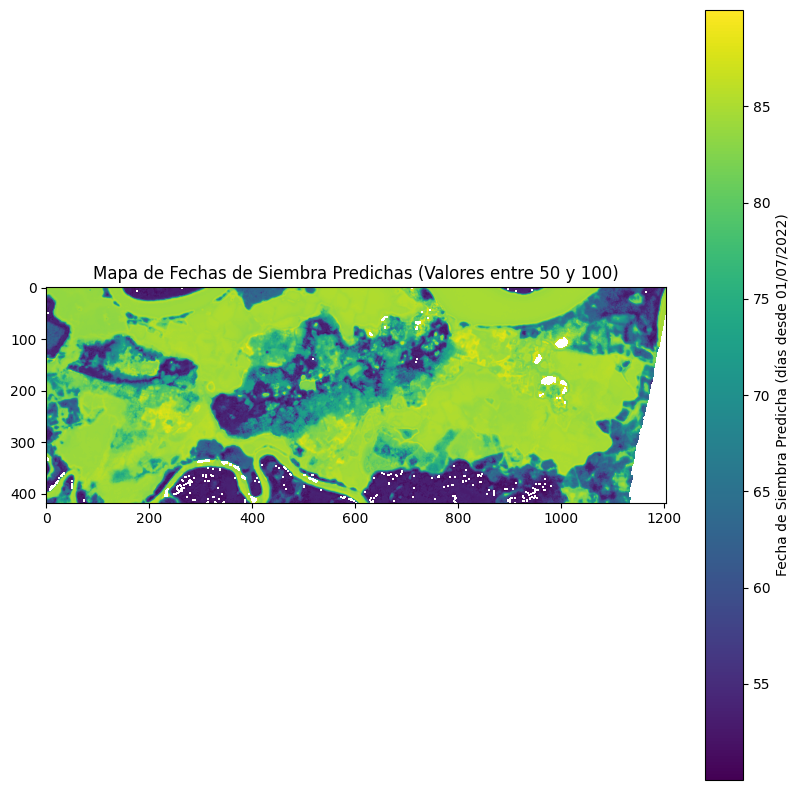

In [ ]:
import numpy as np

# Crear una máscara para valores fuera del rango 50-100
masked_predictions = np.ma.masked_outside(predictions_image, 50, 90)

# Visualizar la imagen predicha con la máscara
plt.figure(figsize=(10, 10))
plt.imshow(masked_predictions, cmap='viridis')
plt.colorbar(label='Fecha de Siembra Predicha (días desde 01/07/2022)')
plt.title('Mapa de Fechas de Siembra Predichas (Valores entre 50 y 100)')
plt.show()
